## This model has the following characteristics:
* No feature engineering
* Applying bidirectional Conv1D to raw transactions

In [1]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow import set_random_seed
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.preprocessing.text import *

Using TensorFlow backend.


### Read Data

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head(10)

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
5,0,2007-05-13 00:00:00,강남점,127105,기초 화장품,화장품,3000000
6,0,2007-05-13 00:00:00,강남점,321101,디자이너부틱,디자이너,11264000
7,0,2007-05-13 00:00:00,강남점,443204,비지니스군,셔츠,975000
8,0,2007-06-09 00:00:00,강남점,9112,유제품,축산가공,85000
9,0,2007-06-09 00:00:00,강남점,72196,건강식품,건강식품,2340000


### Transform Data

In [3]:
max_features = 100000
max_len = 100
emb_dim = 128

# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

for i in range(X_train.shape[0]):
    x = np.unique(X_train[i])
    y = np.array([])
    for j in range(5):
        y = np.append(y, np.random.choice(x, len(x), replace=False))
    X_train[i] = y    
#    X_train[i] = np.random.choice(x, len(x), replace=False)

for i in range(X_test.shape[0]):
    x = np.unique(X_test[i])
    y = np.array([])
    for j in range(5):
        y = np.append(y, np.random.choice(x, len(x), replace=False))
    X_test[i] = y    
#    X_test[i] = np.random.choice(x, len(x)*5)    
    
# Pads sequences to the same length
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)

X_train.shape, X_test.shape

((3500, 100), (2482, 100))

### Build Models

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
forward (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          12800000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 32)            12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 32)            3104      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0   

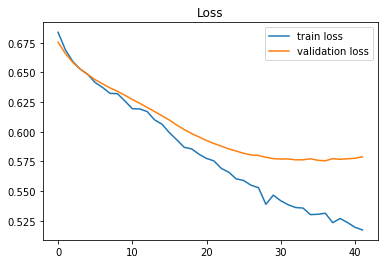

In [4]:
from keras.models import Model
from keras import Input
from keras import layers
from keras.optimizers import RMSprop
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping

# Define the Model & its Architecture
in_f = Input(shape=(max_len,), dtype='int32', name='forward')
x = layers.Embedding(max_features, emb_dim)(in_f)
x = layers.Conv1D(32, 3, activation='elu')(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(32, 3, activation='elu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = Model(in_f, out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.2, callbacks=[EarlyStopping(patience=5)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

### Make Submissions

In [5]:
pred = model.predict(X_test)[:,0]
fname = 'conv1d_submissions.csv'
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'conv1d_submissions.csv' is ready to submit.


## End